# Entry 29b notebook - Thresholds - Profit and cost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

from sklearn.datasets import load_digits, fetch_openml

import random

In [3]:
def create_threshold_matrix(y_train, proba_scores):
    df_matrix = pd.DataFrame()
    for th in np.arange(0.0, 1.01, 0.01):
        tn, fp, fn, tp = confusion_matrix(y_train, (proba_scores >= th)).ravel()
        df_matrix = pd.concat([df_matrix, pd.DataFrame([[th, tp, fp, fn]])])
    df_matrix.columns = ['threshold', 'tp', 'fp', 'fn']
    return df_matrix

def profit_calc(tp_cost, fp_cost, fn_cost, count_matrix):
    profit_df = pd.concat([count_matrix['threshold'], ((count_matrix['tp'] * tp_cost) - (count_matrix['fp'] * tp_cost) - (count_matrix['fn'] * fn_cost))], axis=1)
    profit_df.columns = ['threshold', 'profit']
    return profit_df

def proba_cost_calc(fn_cost, fp_cost, event_proba):
    proba_cost = (event_proba * fn_cost) / (event_proba * fp_cost + (1 - event_proba) * fn_cost)
    return proba_cost

def norm_expect_cost(pcf, threshold_matrix):
    pcf_matrix = pcf * (1 - threshold_matrix['tp']) + (1 - pcf) * threshold_matrix['fp']
    pcf_df = pd.concat([threshold_matrix['threshold'], pcf_matrix], axis=1)
    pcf_df.columns = ['threshold', 'nec']
    return pcf_df

## Make dataset and fit model

In [4]:
titanic = fetch_openml('titanic', version=1, as_frame=True)
df_raw = titanic.data
target = titanic.target

In [5]:
features = ['pclass', 'sex', 'sibsp', 'parch']
X = df_raw.loc[:, features]
X['sex'] = X['sex'].astype('category').cat.codes
y = target.copy().astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12)
pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7824427480916031

### y scores

In [6]:
train_scores = cross_val_predict(pipe, X_train, y_train, cv=3, method='predict_proba')[:,1]

### Profit

In [13]:
thresholds = np.arange(0.0, 1.01, 0.01)
threshold_matrix = create_threshold_matrix(y_train, train_scores)

tp_cost, fp_cost, fn_cost = [random.randrange(100) for s in [1,2,3]]
print("TP Cost:", tp_cost, '\nFP Cost:', fp_cost, '\nFN Cost:', fn_cost)

TP Cost: 72 
FP Cost: 91 
FN Cost: 75


In [14]:
profit = profit_calc(tp_cost, fp_cost, fn_cost, threshold_matrix)
profit

,threshold,profit
0,0.00,-18216
0,0.01,-18216
0,0.02,-18216
0,0.03,-18144
0,0.04,-17784
...,...,...
0,0.96,-29775
0,0.97,-29775
0,0.98,-29775
0,0.99,-29775


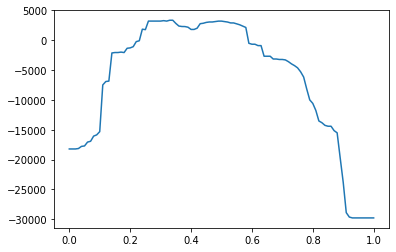

In [18]:
plt.plot(profit['threshold'], profit['profit'])

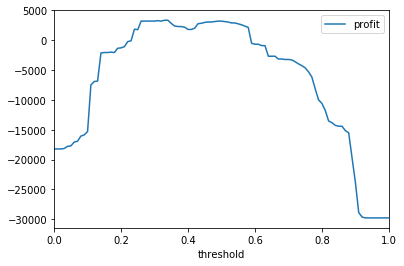

In [19]:
profit.plot('threshold', 'profit')

### Probability cost function

In [15]:
event_proba = y_train.sum() / y_train.size
pcf = proba_cost_calc(fn_cost, fp_cost, event_proba)
pcf

0.3508017484124086

### Normalized expected cost

In [16]:
nec = norm_expect_cost(pcf, threshold_matrix)
nec

,threshold,nec
0,0.00,283.061371
0,0.01,283.061371
0,0.02,283.061371
0,0.03,282.412173
0,0.04,279.166182
...,...,...
0,0.96,0.350802
0,0.97,0.350802
0,0.98,0.350802
0,0.99,0.350802


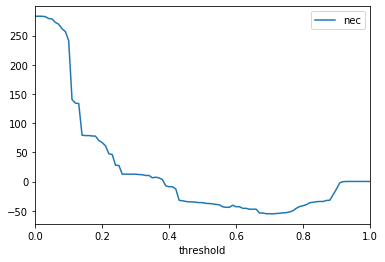

In [20]:
nec.plot('threshold', 'nec')